In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import torch
from tqdm import tqdm

from sklearn.svm import SVC
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score

import pathlib
pathlib.PosixPath = pathlib.WindowsPath
from pathlib import Path
import joblib
import os
from datetime import datetime
import uuid
import json
import shutil

from kcm.utils import load_koopman_model, create_discovery_run_dir, save_discovery_params, save_plot, save_artifact, copy_koopman_params_to_discovery

from kcm.koopman_category_model import KoopmanCategoryModel
from kcm.basic_feature_extract import BasicFeatureExtractor
from kcm.discovery import (
    CategoryDiscoveryTrainer,
    train_test_split_indices,
    prep_data_for_discovery,
    check_histograms,
    sup_con_loss,
    BaselineModel,
    HASHHead,
    cluster_acc,
    split_cluster_acc_v1,
    split_cluster_acc_v2,
    create_hash_ids,
    plot_scores
)
from kcm.utils import fix_colab_path, load_koopman_and_discoveries


plt.style.use('default')

In [2]:
# # Big 2-Dimensional dataset
# KCM_20250812_144800_006d0b9b: train_classes = range(7)
# KCM_20250815_183024_3168acc0: train_classes = range(7), NOISY
# KCM_20250812_154841_f871f182: train_classes = range(3)
# KCM_20250815_195158_3c61bd10: train_classes = range(3), NOISY

# # Small 2-Dimensional dataset
# KCM_20250812_225649_79087582: train_classes = range(3)
# KCM_20250815_193653_2727b520: train_classes = range(3), NOISY
# KCM_20250812_231933_fa8f8010: train_classes = range(2)
# KCM_20250815_194527_425d0fa5: train_classes = range(2), NOISY

# # Big 3-dimensional dataset
# KCM_20250814_233322_1f5f6eec: train_classes = range(5)
# KCM_20250818_122509_dbadfb78: train_classes = range(5), NOISY
# KCM_20250814_223735_8204d02b: train_classes = range(3)
# KCM_20250818_155036_2d80c710: train_classes = range(3), NOISY

# # Small 3-dimensional dataset
# KCM_20250815_040115_7beba451: train_classes = range(3)
# KCM_20250818_165925_d4f6293e: train_classes = range(3), NOISY
# KCM_20250815_041107_7f05a23f: train_classes = range(2)
# KCM_20250818_174401_7dc47c3f: train_classes = range(2), NOISY

In [3]:
dimensions = []
num_cats = []
noisy_data = []
train_classes = []
test_classes = []
output_dims = []
kcm_trainers = []
basic_trainers = []

folders = ['KCM_20250812_144800_006d0b9b',
           'KCM_20250815_183024_3168acc0',
           'KCM_20250812_154841_f871f182',
           'KCM_20250815_195158_3c61bd10',
           'KCM_20250812_225649_79087582',
           'KCM_20250815_193653_2727b520',
           'KCM_20250812_231933_fa8f8010',
           'KCM_20250815_194527_425d0fa5',
           'KCM_20250814_233322_1f5f6eec',
           'KCM_20250818_122509_dbadfb78',
           'KCM_20250814_223735_8204d02b',
           'KCM_20250818_155036_2d80c710',
           'KCM_20250815_040115_7beba451',
           'KCM_20250818_165925_d4f6293e',
           'KCM_20250815_041107_7f05a23f',
           'KCM_20250818_174401_7dc47c3f'
          ]

for folder in tqdm(folders):
    results = load_koopman_and_discoveries(folder)
    params = results["params"]
    
    dimension_mapping = {results['discoveries'][i]['params']['output_dim'] : i for i in range(len(results['discoveries']))}

    for output_dim in [4,6,8]:
        kcm_trainer = results['discoveries'][dimension_mapping[output_dim]]['kcm_trainer']
        basic_trainer = results['discoveries'][dimension_mapping[output_dim]]['basic_trainer']
        results_dim = results['discoveries'][dimension_mapping[output_dim]]['params']['output_dim']
        
        assert output_dim == results_dim
        
        dim = int(Path(params[3]).parent.stem[0])
        cats = int(params[0][-2:])
        noisy = params[13][-5:].replace(' ','').lower() == 'true'
        train = int(params[15][-2])
        test = cats - train
    
        dimensions.append(dim)
        num_cats.append(cats)
        noisy_data.append(noisy)
        train_classes.append(train)
        test_classes.append(test)
        output_dims.append(output_dim)
        kcm_trainers.append(kcm_trainer)
        basic_trainers.append(basic_trainer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:42<00:00,  2.66s/it]


In [8]:
index = 100
kcm_new_strict_hungarian = [kcm_trainers[i].new_global_scores[index-1] for i in range(len(dimensions))]
kcm_old_strict_hungarian = [kcm_trainers[i].old_global_scores[index-1] for i in range(len(dimensions))]
kcm_combined_strict_hungarian = [kcm_trainers[i].global_scores[index-1] for i in range(len(dimensions))]
kcm_new_greedy_hungarian = [kcm_trainers[i].new_scores[index-1] for i in range(len(dimensions))]
kcm_old_greedy_hungarian = [kcm_trainers[i].old_scores[index-1] for i in range(len(dimensions))]
kcm_combined_greedy_hungarian = [kcm_trainers[i].weighted_scores[index-1] for i in range(len(dimensions))]

basic_new_strict_hungarian = [basic_trainers[i].new_global_scores[index-1] for i in range(len(dimensions))]
basic_old_strict_hungarian = [basic_trainers[i].old_global_scores[index-1] for i in range(len(dimensions))]
basic_combined_strict_hungarian = [basic_trainers[i].global_scores[index-1] for i in range(len(dimensions))]
basic_new_greedy_hungarian = [basic_trainers[i].new_scores[index-1] for i in range(len(dimensions))]
basic_old_greedy_hungarian = [basic_trainers[i].old_scores[index-1] for i in range(len(dimensions))]
basic_combined_greedy_hungarian = [basic_trainers[i].weighted_scores[index-1] for i in range(len(dimensions))]

In [9]:
df = pd.DataFrame(
    dict(dimensions=dimensions,
         num_cats=num_cats,
         noisy_data=noisy_data,
         train_classes=train_classes,
         test_classes=test_classes,
         output_dims=output_dims,
         kcm_new_strict_hungarian=kcm_new_strict_hungarian,
         kcm_old_strict_hungarian=kcm_old_strict_hungarian,
         kcm_combined_strict_hungarian=kcm_combined_strict_hungarian,
         kcm_new_greedy_hungarian=kcm_new_greedy_hungarian,
         kcm_old_greedy_hungarian=kcm_old_greedy_hungarian,
         kcm_combined_greedy_hungarian=kcm_combined_greedy_hungarian,
         basic_new_strict_hungarian=basic_new_strict_hungarian,
         basic_old_strict_hungarian=basic_old_strict_hungarian,
         basic_combined_strict_hungarian=basic_combined_strict_hungarian,
         basic_new_greedy_hungarian=basic_new_greedy_hungarian,
         basic_old_greedy_hungarian=basic_old_greedy_hungarian,
         basic_combined_greedy_hungarian=basic_combined_greedy_hungarian
        )
)
df.loc[df['dimensions'].eq(2),'dimensions'] = 1
assert df.shape[0] == df[['dimensions','num_cats','noisy_data','train_classes','test_classes','output_dims']].drop_duplicates().shape[0]

koopman


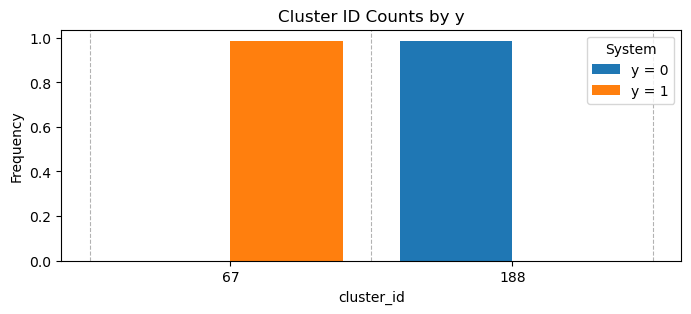

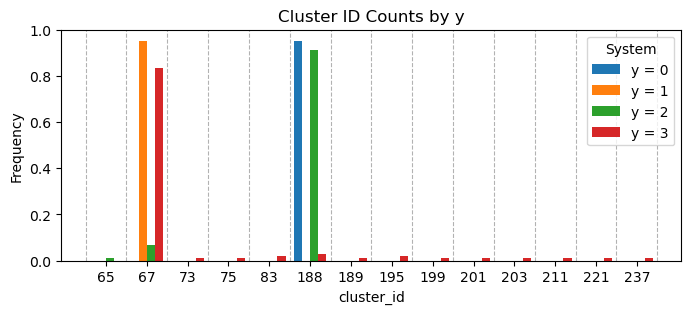

basic


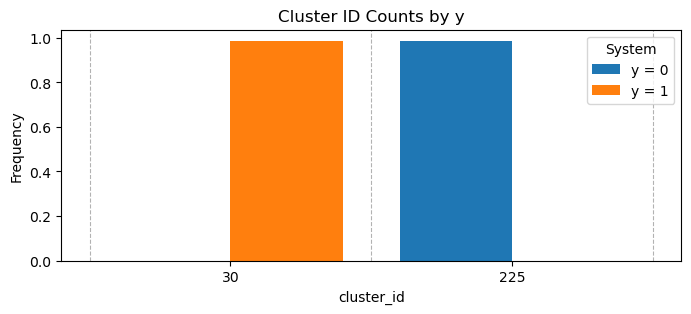

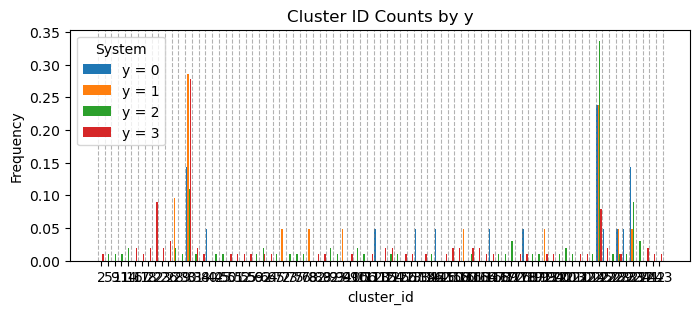

In [10]:
index = 100
print('koopman')
kcm_trainers[44].plot_hashes(index=index-1,
                        split_testing=False,
                        show=True,
                        save_dir=None,
                        base_filename='koopman_hashes'
                       )
print('basic')
basic_trainers[44].plot_hashes(index=index-1,
                        split_testing=False,
                        show=True,
                        save_dir=None,
                        base_filename='koopman_hashes'
                       )
print('\n\n\n')

In [11]:
dimensions = 3
num_cats = 4
noisy_data = False
train_classes = 2

df.loc[
    df['dimensions'].eq(dimensions) &
    df['num_cats'].eq(num_cats) &
    df['noisy_data'].eq(noisy_data) &
    df['train_classes'].eq(train_classes)
    ]

,dimensions,num_cats,noisy_data,train_classes,test_classes,output_dims,kcm_new_strict_hungarian,kcm_old_strict_hungarian,kcm_combined_strict_hungarian,kcm_new_greedy_hungarian,kcm_old_greedy_hungarian,kcm_combined_greedy_hungarian,basic_new_strict_hungarian,basic_old_strict_hungarian,basic_combined_strict_hungarian,basic_new_greedy_hungarian,basic_old_greedy_hungarian,basic_combined_greedy_hungarian
42,3,4,False,2,2,4,0.930,0.0,0.775000,0.930,1.0,0.941667,0.610,0.150,0.533333,0.610,0.425,0.579167
43,3,4,False,2,2,6,0.895,0.0,0.745833,0.895,1.0,0.912500,0.315,0.075,0.275000,0.315,0.525,0.350000
44,3,4,False,2,2,8,0.880,0.0,0.733333,0.880,1.0,0.900000,0.310,0.125,0.279167,0.310,0.275,0.304167


In [12]:
metric = 'basic_combined_greedy_hungarian'
((df.loc[df['noisy_data'].eq(True),metric].values - df.loc[df['noisy_data'].eq(False),metric].values) > 0).sum() / 24
# df.loc[df['noisy_data'].eq(True),['dimensions','num_cats','noisy_data','train_classes']]

np.float64(0.7083333333333334)

In [14]:
(df['kcm_combined_strict_hungarian'] - df['basic_combined_strict_hungarian']).mean()

np.float64(0.1989405521895153)

In [16]:
(df['kcm_combined_strict_hungarian'] - df['basic_combined_strict_hungarian']).mean()

np.float64(0.1989405521895153)

In [19]:
(df.loc[df['noisy_data'].eq(False),'kcm_combined_strict_hungarian'].values - df.loc[df['noisy_data'].eq(False),'basic_combined_strict_hungarian'].values).mean()

np.float64(0.2614022461456672)

In [20]:
(df.loc[df['noisy_data'].eq(True),'kcm_combined_strict_hungarian'].values - df.loc[df['noisy_data'].eq(True),'basic_combined_strict_hungarian'].values).mean()

np.float64(0.1364788582333634)

In [247]:
metric = 'kcm_combined_strict_hungarian'
((df.loc[df['output_dims'].eq(6),metric].values - df.loc[df['output_dims'].eq(8),metric].values) > 0).sum()

np.int64(13)

In [134]:
# df.to_csv('../data/metrics.csv')

In [216]:
# for trainer, noise in zip(kcm_trainers,df['noisy_data']):
#     print(noise)
#     trainer.plot_loss(log=False,show=True)

In [250]:
# kcm_trainers[0].new_global_scores[99], kcm_trainers[3].new_global_scores[99]

# # kcm_trainers[3]
# kcm_trainers[6].plot_hashes(index=99,
#     split_testing=False,
#     show=True,
#     save_dir=None,
#     base_filename='koopman_hashes')

In [207]:
# kcm_trainers[9].plot_hashes(index=99,
#     split_testing=False,
#     show=True,
#     save_dir=None,
#     base_filename='koopman_hashes')

2


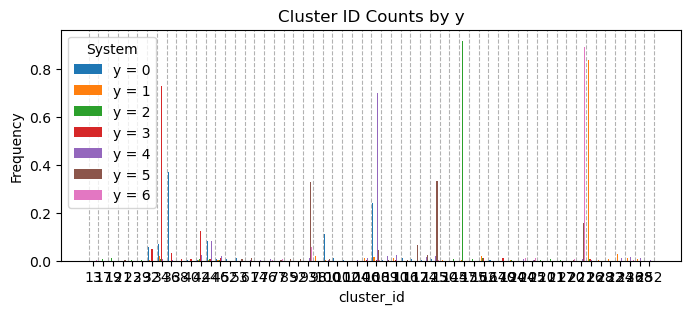

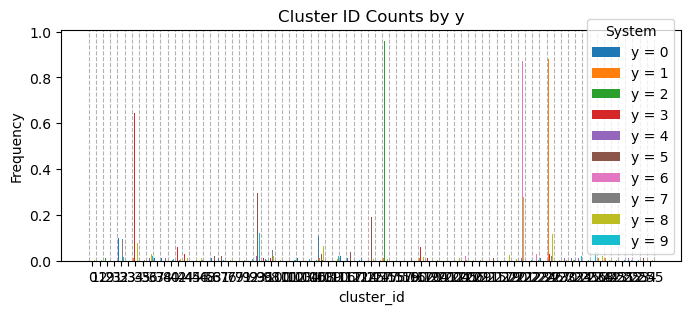





5


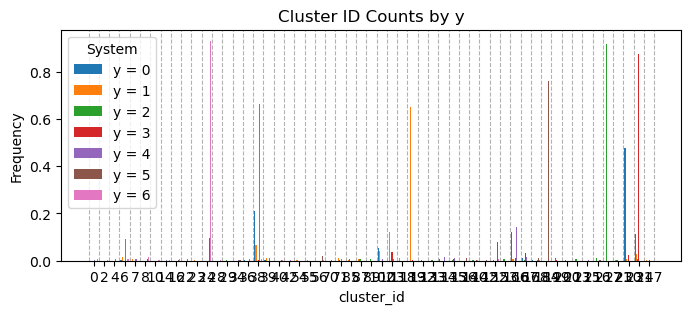

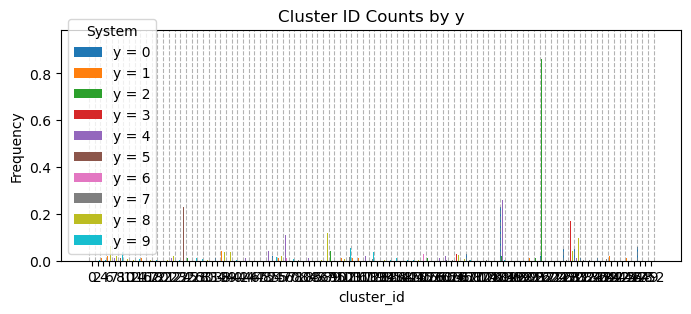





8


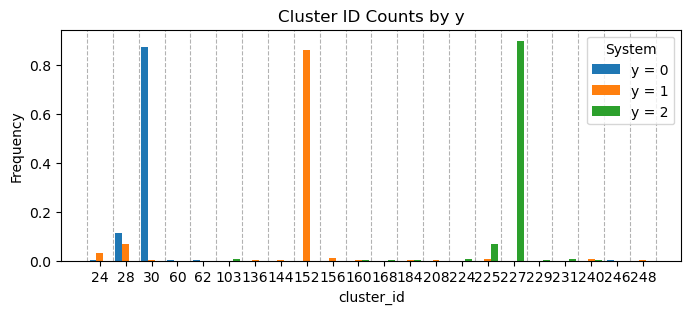

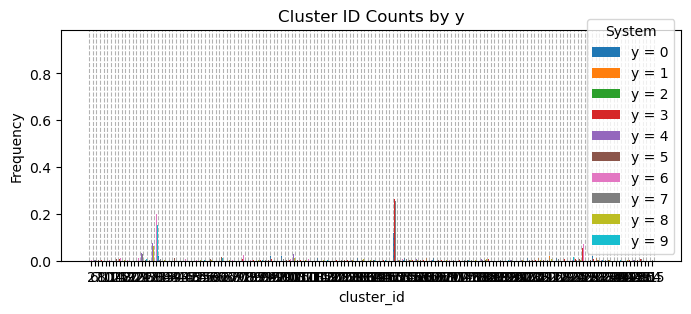





11


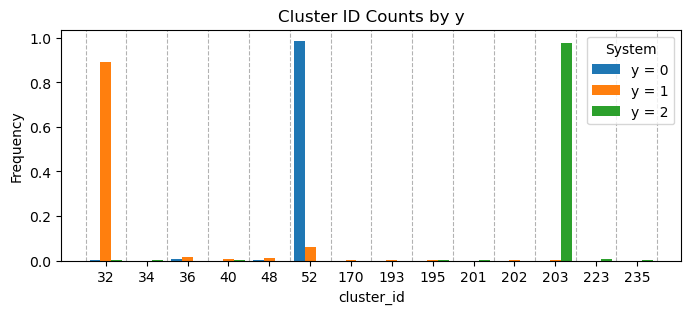

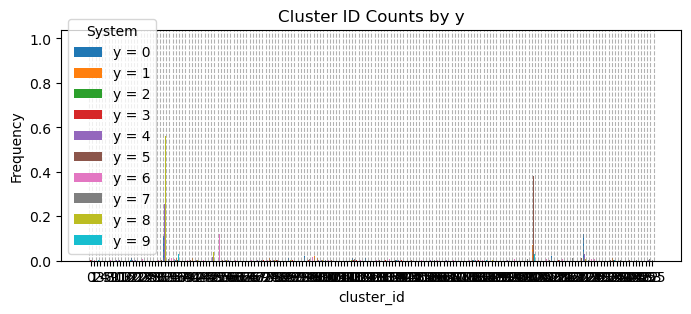





14


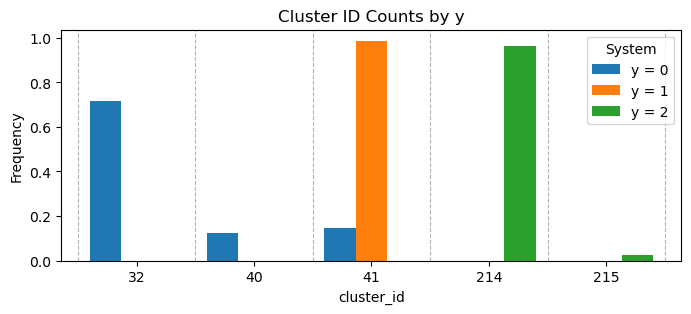

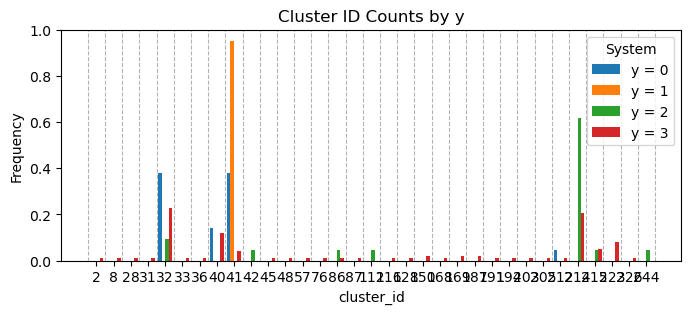





17


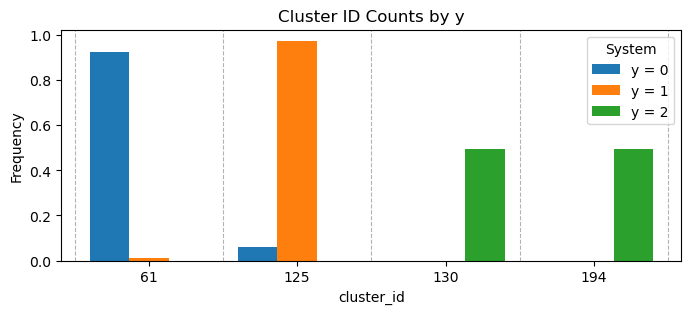

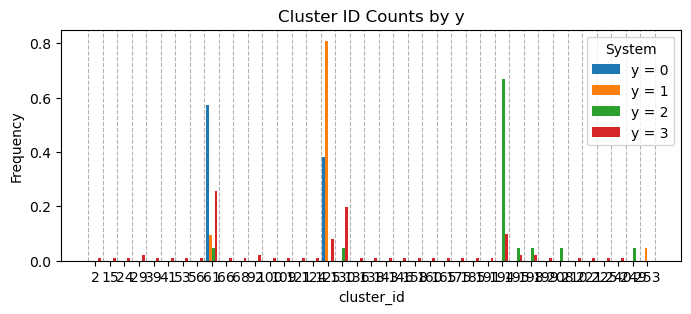





20


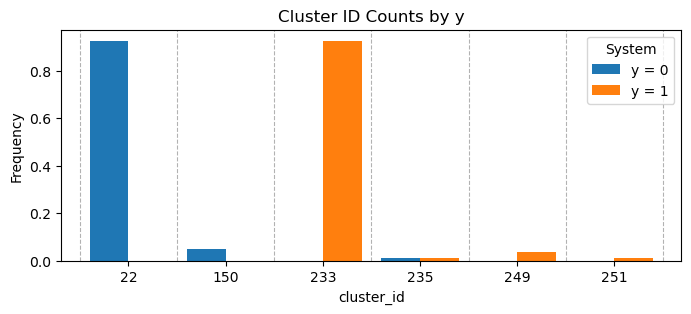

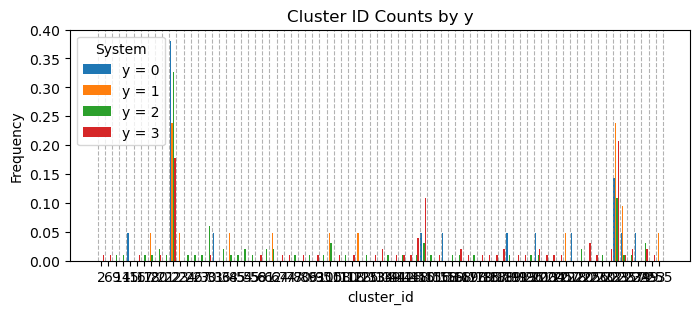





23


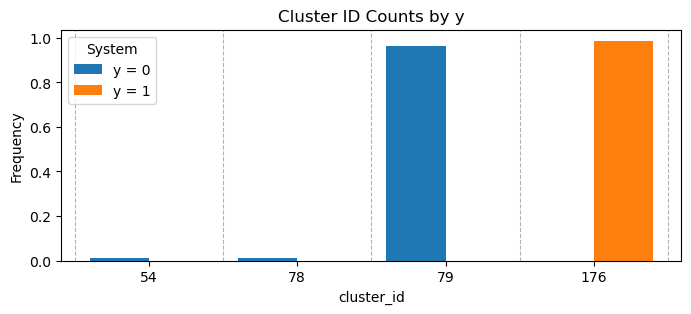

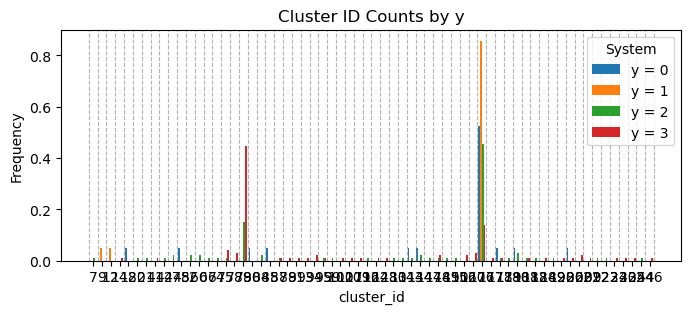





26


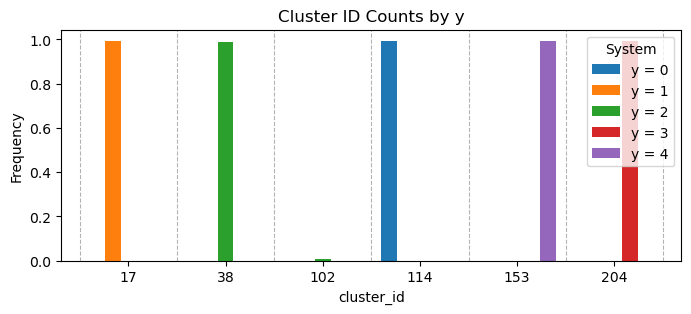

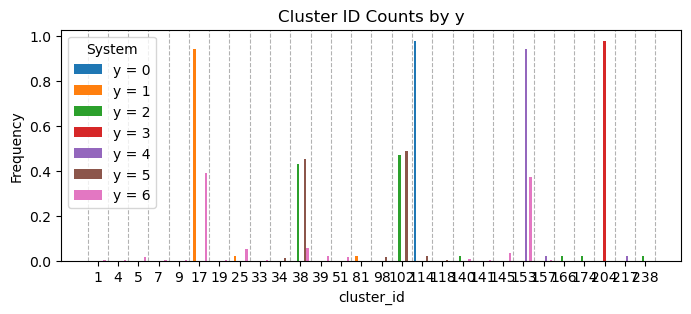





29


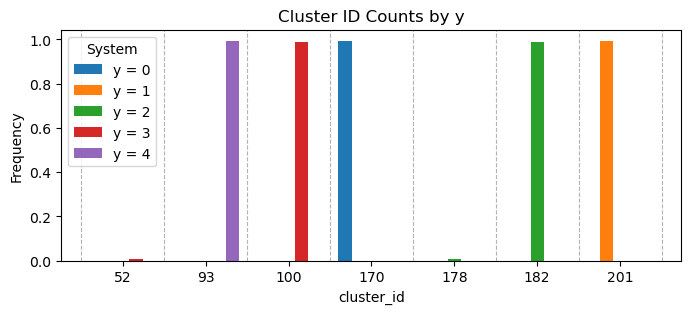

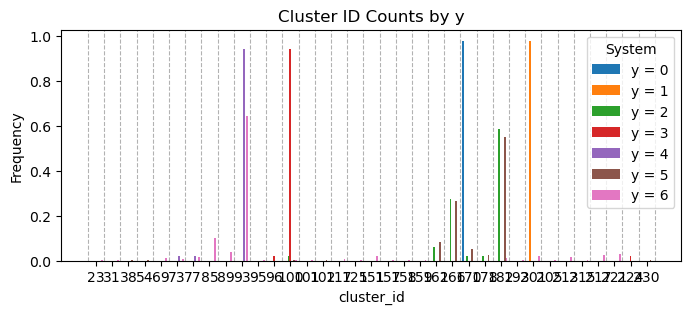





32


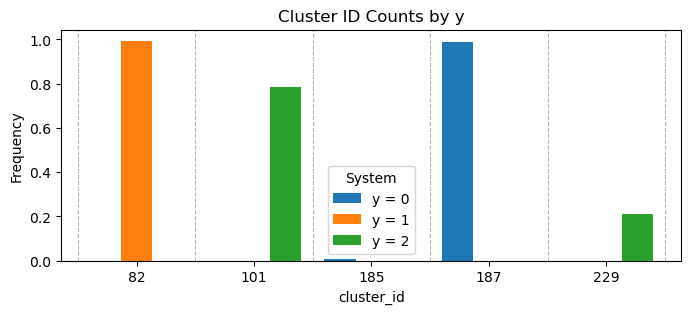

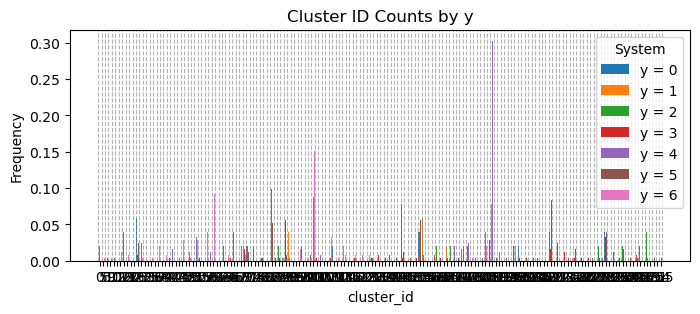





35


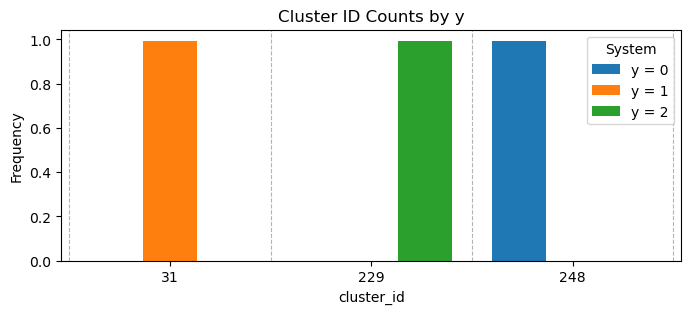

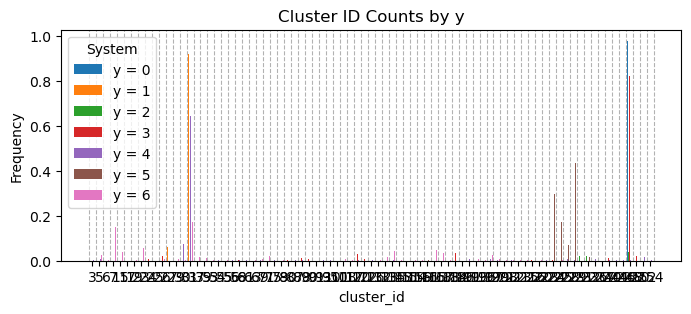





38


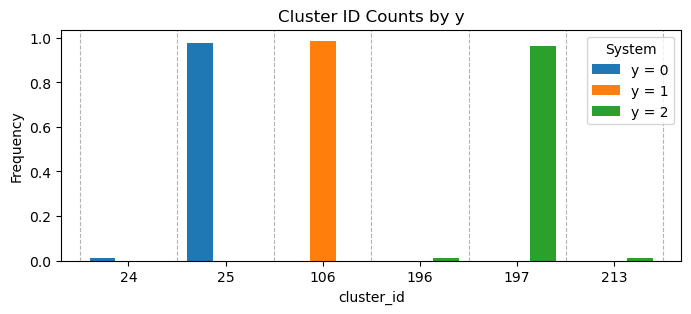

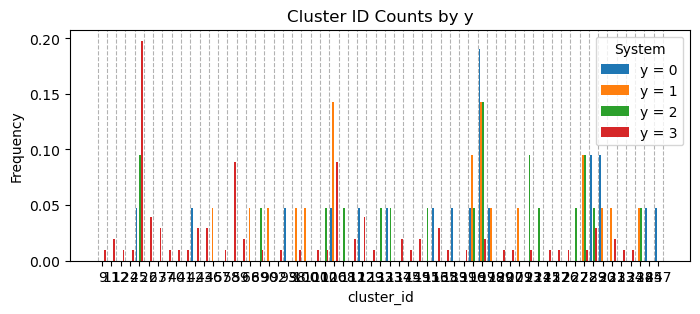





41


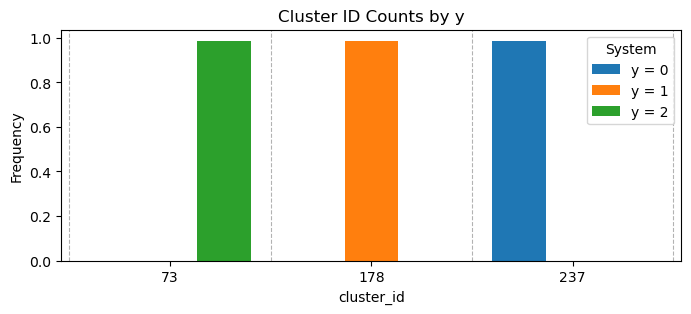

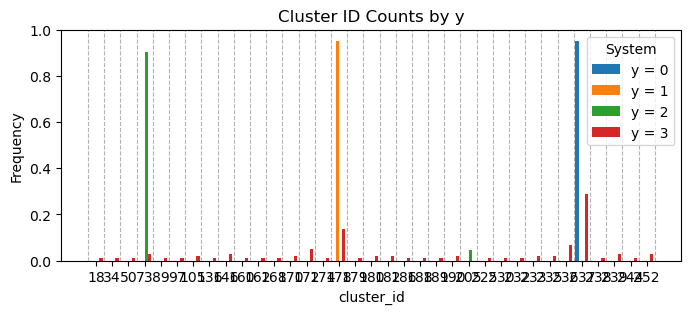





44


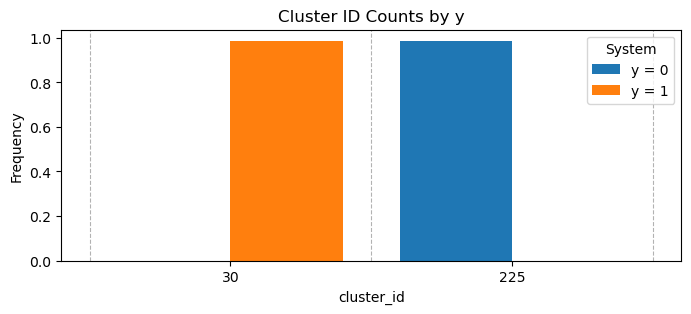

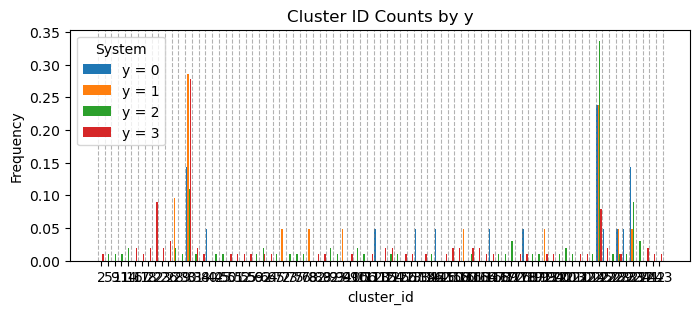





47


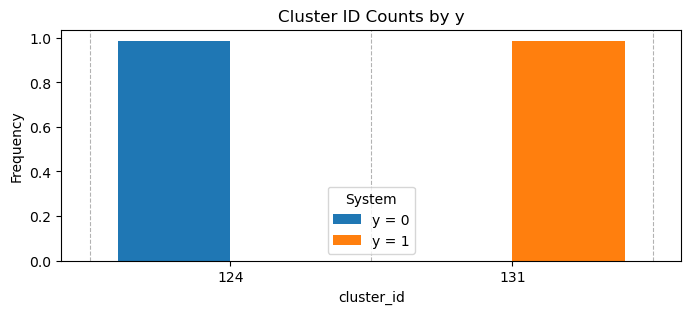

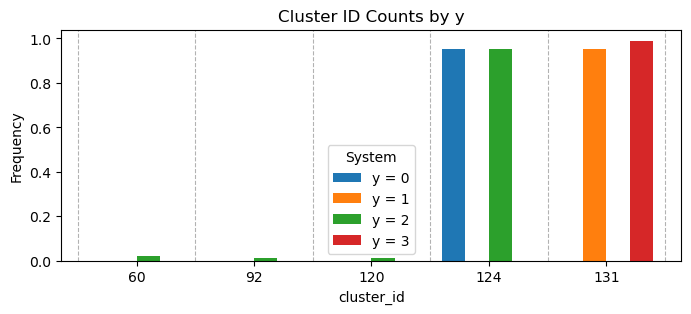

In [259]:
for index in df.loc[df['output_dims'].eq(8)].index:
    print(index)
    trainer = basic_trainers[index]
    trainer.plot_hashes(index=99,
                        split_testing=False,
                        show=True,
                        save_dir=None,
                        base_filename='koopman_hashes'
                       )
    print('\n\n\n')